# This notebook demonstrates plotting diurnal cycle composites of MCS precipitation Hovmoller diagram by seasons
## The monthly data is produced by: 
* /Analysis/calc_tbpf_mcs_monthly_rainhov.py

In [83]:
import numpy as np
import glob, os
import xarray as xr
from scipy import fftpack
import time, datetime, calendar, pytz
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import colorcet as cc
%matplotlib inline

In [84]:
# Sepcify directory of the MCS track stats file
rootdir = '/pscratch/sd/s/souravt/PyFLEXTRKR/TGW_MCS/HIST/'
# Specify region name
region = 'SGP'

obsdir = f'{rootdir}OBS/stats/monthly/'
wrfdir = f'{rootdir}WRF/stats/monthly/'
obsfiles = sorted(glob.glob(f'{obsdir}mcs_rainhov_{region}*.nc'))
wrffiles = sorted(glob.glob(f'{wrfdir}mcs_rainhov_{region}*.nc'))

nfiles_gpm = len(obsfiles)
nfiles_wrf = len(wrffiles)
print(f'Number of files (OBS): {nfiles_gpm}')
print(f'Number of files (WRF): {nfiles_wrf}')

figdir = f'/global/cfs/cdirs/m2637/zfeng/TGW_MCS/figures/'
os.makedirs(figdir, exist_ok=True)
print(f'Fig directory: {figdir}')

# # Specify time range to use for the composite period
# sdate = '2018-12-01'
# edate = '2019-03-01'

Number of files (OBS): 104
Number of files (WRF): 104
Fig directory: /global/cfs/cdirs/m2637/zfeng/TGW_MCS/figures/


## Function to compute diurnal cycle amplitude and phase for 1D data

In [85]:
def harmonic_phase_amplitude(var, nharm, hr1, binsize=1.0):
    """
    Calculates the harmonic phase and amplitude for the requested number
    of harmonics. The phase indicates the location of the peak closest to
    T=0 for each harmonic along the T-axis--it can be on either side of 0.
    Arguments:
       var   = array to be analyzed, XT ordering assumed.
       nharm = number of harmonics to calculate
       hr1   = hour of the first time in the time series--used to adj. phase to be 0 at 0 hrs
       binsize = size of the hour bin for calculating phase. default=1.0
    Returns:
       amp[nharm] = amplitude of each harmonic
       phs[nharm] = phase of each harmonic, with 0 phase set to hour 0
       pvar[nharm] = percent variance explained
    Created: William.Gustafson@pnnl.gov, 17-Jan-2014
    Last modified: William.Gustafson@pnnl.gov, 22-Jan-2014
    Modified by: Zhe.Feng@pnnl.gov, 10-Jan-2019
    """
    nt = var.shape[-1]
    w = float(nt) * binsize / (2.*np.arccos(-1.))
    ft = fftpack.fft(var, axis=-1)

    # 0th index returned by fft is the trend, so harmonics start at 1
    ampall = np.abs(ft)[1:] * 2./float(nt)  # need all amplitudes to get total variance
    amp = ampall[0:nharm]
    phs = np.angle(ft)[1:nharm+1]

    totvar = 0.5*np.sum(ampall*ampall)  # total variance
    zeros = np.where(totvar < 1e-12, True, False)  # Need to mask out zero variance values for getting percent values
    totvar_nozeros = np.where(zeros, 1., totvar)
    pvar = np.empty_like(amp)

    for n in range(nharm):
        np1 = n + 1  # adjust by one to get the harmonic number vs. its index
        phs_offset_max = float(nt) * binsize / float(np1)  # max possible phase offset for this harmonic

        # Have to switch rotation direction of the phase angle to get
        # where first peak occurs. We want it to indicate the angle where
        # the peak occurs. We also do the shift here for the offset due
        # to the first hour not being at 0 (what was sent into this routine).
        phs[n] = phs_offset_max - phs[n] * w / float(np1) + hr1

        # Now, we adjust for a phase that might be a multiple of the given harmonic.
        phs[n] = np.where(phs[n]>phs_offset_max, phs[n]-phs_offset_max, phs[n])
        phs[n] = np.where(phs[n]<0, phs[n] + float(nt)*binsize/float(np1), phs[n])

        # Get percent variance explained by each harmonic.
        pvar[n] = np.where(zeros, 0., 100.*(0.5*amp[n]*amp[n])/totvar_nozeros)
    
    return amp, phs, pvar

## Function to compute diurnal cycle amplitude and phase for 2D data

In [86]:
def harmonic_phase_amplitude2d(var, nharm, hr1, binsize=1.0):
    """
    Calculates the harmonic phase and amplitude for the requested number
    of harmonics. The phase indicates the location of the peak closest to
    T=0 for each harmonic along the T-axis--it can be on either side of 0.
    Arguments:
       var   = array to be analyzed, YXT ordering assumed.
       nharm = number of harmonics to calculate
       hr1   = hour of the first time in the time series--used to adj. phase to be 0 at 0 hrs
       binsize = size of the hour bin for calculating phase. default=1.0
    Returns:
       amp[nharm] = amplitude of each harmonic
       phs[nharm] = phase of each harmonic, with 0 phase set to hour 0
       pvar[nharm] = percent variance explained
    Created: William.Gustafson@pnnl.gov, 17-Jan-2014
    Last modified: William.Gustafson@pnnl.gov, 22-Jan-2014
    Modified by: Zhe.Feng@pnnl.gov, 10-Jan-2019
    """
    nt = var.shape[-1]
    w = float(nt) * binsize / (2.*np.arccos(-1.))
    ft = fftpack.fft(var, axis=-1)

    # 0th index returned by fft is the trend, so harmonics start at 1
    ampall = np.abs(ft)[:, 1:] * 2./float(nt)  # need all amplitudes to get total variance
    amp = ampall[:, 0:nharm]
    phs = np.angle(ft)[:, 1:nharm+1]

    totvar = 0.5*np.sum(ampall*ampall, axis=1)  # total variance
    zeros = np.where(totvar < 1e-12, True, False)  # Need to mask out zero variance values for getting percent values
    totvar_nozeros = np.where(zeros, 1., totvar)
    pvar = np.empty_like(amp)

    for n in range(nharm):
        np1 = n + 1  # adjust by one to get the harmonic number vs. its index
        phs_offset_max = float(nt) * binsize / float(np1)  # max possible phase offset for this harmonic

        # Have to switch rotation direction of the phase angle to get
        # where first peak occurs. We want it to indicate the angle where
        # the peak occurs. We also do the shift here for the offset due
        # to the first hour not being at 0 (what was sent into this routine).
        phs[:,n] = phs_offset_max - phs[:,n] * w / float(np1) + hr1

        # Now, we adjust for a phase that might be a multiple of the given harmonic.
        phs[:,n] = np.where(phs[:,n]>phs_offset_max, phs[:,n]-phs_offset_max, phs[:,n])
        phs[:,n] = np.where(phs[:,n]<0, phs[:,n] + float(nt)*binsize/float(np1), phs[:,n])

        # Get percent variance explained by each harmonic.
        pvar[:,n] = np.where(zeros, 0., 100.*(0.5*amp[:,n]*amp[:,n])/totvar_nozeros)
    
    return amp, phs, pvar

In [87]:
# Read OBS data
dsobs = xr.open_mfdataset(obsfiles, concat_dim='time', combine='nested')
# dsobs = dsobs.sel(time=slice(sdate, edate))
lon_obs = dsobs.lon

In [88]:
dsobs.attrs['startlat'], dsobs.attrs['endlat']

(30.0, 38.0)

In [89]:
# Read Model data
dswrf = xr.open_mfdataset(wrffiles, concat_dim='time', combine='nested')
# dswrf = dswrf.sel(time=slice(sdate, edate))
lon_wrf = dswrf.lon

In [90]:
# Subset Hovmoller dataset by season, group by hour of the day, and average on the time dimension (OBS)
totpcphovdiur_obs_MAM = dsobs.sel(time=dsobs['time.season'] == 'MAM').precipitation.groupby('time.hour').mean(dim='time')
mcspcphovdiur_obs_MAM = dsobs.sel(time=dsobs['time.season'] == 'MAM').mcs_precipitation.groupby('time.hour').mean(dim='time')
totpcphovdiur_obs_JJA = dsobs.sel(time=dsobs['time.season'] == 'JJA').precipitation.groupby('time.hour').mean(dim='time')
mcspcphovdiur_obs_JJA = dsobs.sel(time=dsobs['time.season'] == 'JJA').mcs_precipitation.groupby('time.hour').mean(dim='time')

In [91]:
# Subset Hovmoller dataset by season, group by hour of the day, and average on the time dimension (WRF)
totpcphovdiur_wrf_MAM = dswrf.sel(time=dswrf['time.season'] == 'MAM').precipitation.groupby('time.hour').mean(dim='time')
mcspcphovdiur_wrf_MAM = dswrf.sel(time=dswrf['time.season'] == 'MAM').mcs_precipitation.groupby('time.hour').mean(dim='time')
totpcphovdiur_wrf_JJA = dswrf.sel(time=dswrf['time.season'] == 'JJA').precipitation.groupby('time.hour').mean(dim='time')
mcspcphovdiur_wrf_JJA = dswrf.sel(time=dswrf['time.season'] == 'JJA').mcs_precipitation.groupby('time.hour').mean(dim='time')

In [92]:
# # Group Hovmoller data by hour of the day, and average on the time dimension (OBS)
# totpcphovdiur_obs = dsobs.precipitation.groupby('time.hour').mean(dim='time')
# mcspcphovdiur_obs = dsobs.mcs_precipitation.groupby('time.hour').mean(dim='time')
# # Longitude values
# lon_obs = dsobs.lon

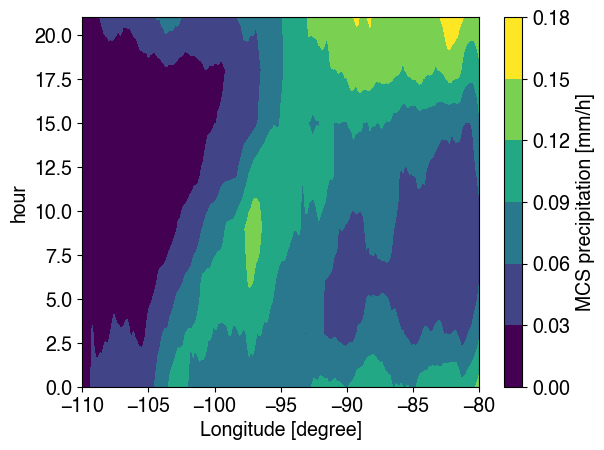

In [93]:
mcspcphovdiur_obs_JJA.plot.contourf()

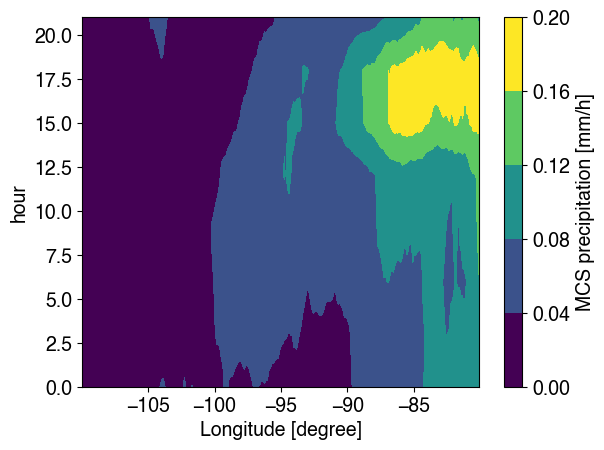

In [94]:
mcspcphovdiur_wrf_JJA.plot.contourf()

In [95]:
# Time zone shift from UTC to Local Time (LT)
timezone_shift = -6

# Make hour bins
hours = np.arange(0, 24.1, 3)
nbins = len(hours)
# Shift UTC time to LT
totpcphovdiur_obs_lt_MAM = np.roll(totpcphovdiur_obs_MAM, timezone_shift, axis=0)
mcspcphovdiur_obs_lt_MAM = np.roll(mcspcphovdiur_obs_MAM, timezone_shift, axis=0)
totpcphovdiur_obs_lt_JJA = np.roll(totpcphovdiur_obs_JJA, timezone_shift, axis=0)
mcspcphovdiur_obs_lt_JJA = np.roll(mcspcphovdiur_obs_JJA, timezone_shift, axis=0)

# Extend 1 hour at the end of the day and copy the 1st hour values 
# to make a nicer 24 h length
totpcphovdiur_obsE_MAM = np.ndarray((nbins, totpcphovdiur_obs_lt_MAM.shape[1]))
totpcphovdiur_obsE_MAM[0:nbins-1,:] = totpcphovdiur_obs_lt_MAM
totpcphovdiur_obsE_MAM[nbins-1,:] = totpcphovdiur_obs_lt_MAM[0,:]

totpcphovdiur_obsE_JJA = np.ndarray((nbins, totpcphovdiur_obs_lt_JJA.shape[1]))
totpcphovdiur_obsE_JJA[0:nbins-1,:] = totpcphovdiur_obs_lt_JJA
totpcphovdiur_obsE_JJA[nbins-1,:] = totpcphovdiur_obs_lt_JJA[0,:]

mcspcphovdiur_obsE_MAM = np.ndarray((nbins, mcspcphovdiur_obs_lt_MAM.shape[1]))
mcspcphovdiur_obsE_MAM[0:nbins-1,:] = mcspcphovdiur_obs_lt_MAM
mcspcphovdiur_obsE_MAM[nbins-1,:] = mcspcphovdiur_obs_lt_MAM[0,:]

mcspcphovdiur_obsE_JJA = np.ndarray((nbins, mcspcphovdiur_obs_lt_JJA.shape[1]))
mcspcphovdiur_obsE_JJA[0:nbins-1,:] = mcspcphovdiur_obs_lt_JJA
mcspcphovdiur_obsE_JJA[nbins-1,:] = mcspcphovdiur_obs_lt_JJA[0,:]

In [96]:
# Shift UTC time to LT
totpcphovdiur_wrf_lt_MAM = np.roll(totpcphovdiur_wrf_MAM, timezone_shift, axis=0)
mcspcphovdiur_wrf_lt_MAM = np.roll(mcspcphovdiur_wrf_MAM, timezone_shift, axis=0)
totpcphovdiur_wrf_lt_JJA = np.roll(totpcphovdiur_wrf_JJA, timezone_shift, axis=0)
mcspcphovdiur_wrf_lt_JJA = np.roll(mcspcphovdiur_wrf_JJA, timezone_shift, axis=0)

# Extend 1 hour at the end of the day and copy the 1st hour values 
# to make a nicer 24 h length
totpcphovdiur_wrfE_MAM = np.ndarray((nbins, totpcphovdiur_wrf_lt_MAM.shape[1]))
totpcphovdiur_wrfE_MAM[0:nbins-1,:] = totpcphovdiur_wrf_lt_MAM
totpcphovdiur_wrfE_MAM[nbins-1,:] = totpcphovdiur_wrf_lt_MAM[0,:]

totpcphovdiur_wrfE_JJA = np.ndarray((nbins, totpcphovdiur_wrf_lt_JJA.shape[1]))
totpcphovdiur_wrfE_JJA[0:nbins-1,:] = totpcphovdiur_wrf_lt_JJA
totpcphovdiur_wrfE_JJA[nbins-1,:] = totpcphovdiur_wrf_lt_JJA[0,:]

mcspcphovdiur_wrfE_MAM = np.ndarray((nbins, mcspcphovdiur_wrf_lt_MAM.shape[1]))
mcspcphovdiur_wrfE_MAM[0:nbins-1,:] = mcspcphovdiur_wrf_lt_MAM
mcspcphovdiur_wrfE_MAM[nbins-1,:] = mcspcphovdiur_wrf_lt_MAM[0,:]

mcspcphovdiur_wrfE_JJA = np.ndarray((nbins, mcspcphovdiur_wrf_lt_JJA.shape[1]))
mcspcphovdiur_wrfE_JJA[0:nbins-1,:] = mcspcphovdiur_wrf_lt_JJA
mcspcphovdiur_wrfE_JJA[nbins-1,:] = mcspcphovdiur_wrf_lt_JJA[0,:]

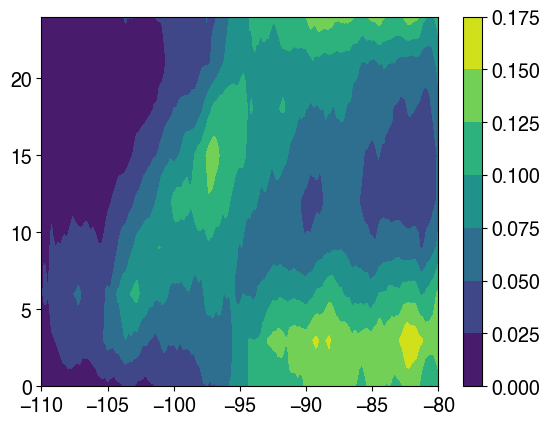

In [97]:
plt.contourf(lon_obs, hours, mcspcphovdiur_obsE_JJA)
plt.colorbar()

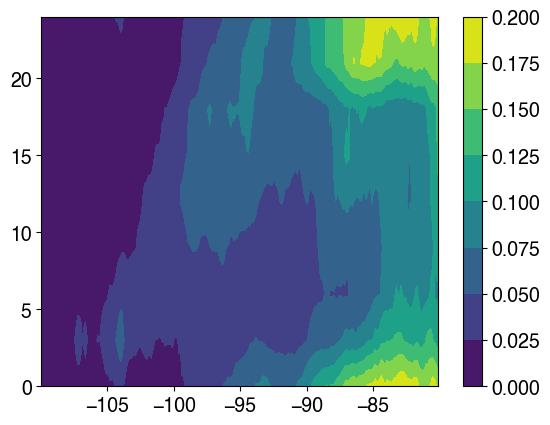

In [98]:
plt.contourf(lon_wrf, hours, mcspcphovdiur_wrfE_JJA)
plt.colorbar()

In [99]:
# MCS precipitation fraction (OBS)
mcspcpfrac_obsE_MAM = (mcspcphovdiur_obsE_MAM / totpcphovdiur_obsE_MAM)*100
mcspcpfrac_wrfE_MAM = (mcspcphovdiur_wrfE_MAM / totpcphovdiur_wrfE_MAM)*100
mcspcpfrac_obsE_JJA = (mcspcphovdiur_obsE_JJA / totpcphovdiur_obsE_JJA)*100
mcspcpfrac_wrfE_JJA = (mcspcphovdiur_wrfE_JJA / totpcphovdiur_wrfE_JJA)*100

In [100]:
# MCS precipitation fraction (wrf)
mcspcpfrac_wrfE_MAM = (mcspcphovdiur_wrfE_MAM / totpcphovdiur_wrfE_MAM)*100
mcspcpfrac_wrfE_MAM = (mcspcphovdiur_wrfE_MAM / totpcphovdiur_wrfE_MAM)*100
mcspcpfrac_wrfE_JJA = (mcspcphovdiur_wrfE_JJA / totpcphovdiur_wrfE_JJA)*100
mcspcpfrac_wrfE_JJA = (mcspcphovdiur_wrfE_JJA / totpcphovdiur_wrfE_JJA)*100

In [101]:
# Compute diurnal cycle amplitude and phase at each longitude
nharm = 4
amp_tot_obs_MAM, phs_tot_obs_MAM, pvar_tot_obs_MAM = harmonic_phase_amplitude2d(np.transpose(totpcphovdiur_obs_lt_MAM), nharm, 0., binsize=3.)
amp_mcs_obs_MAM, phs_mcs_obs_MAM, pvar_mcs_obs_MAM = harmonic_phase_amplitude2d(np.transpose(mcspcphovdiur_obs_lt_MAM), nharm, 0., binsize=3.)
amp_mcsfrac_obs_MAM, phs_mcsfrac_obs_MAM, pvar_mcsfrac_obs_MAM = harmonic_phase_amplitude2d(np.transpose(mcspcpfrac_obsE_MAM), nharm, 0., binsize=3.)

amp_tot_obs_JJA, phs_tot_obs_JJA, pvar_tot_obs_JJA = harmonic_phase_amplitude2d(np.transpose(totpcphovdiur_obs_lt_JJA), nharm, 0., binsize=3.)
amp_mcs_obs_JJA, phs_mcs_obs_JJA, pvar_mcs_obs_JJA = harmonic_phase_amplitude2d(np.transpose(mcspcphovdiur_obs_lt_JJA), nharm, 0., binsize=3.)
amp_mcsfrac_obs_JJA, phs_mcsfrac_obs_JJA, pvar_mcsfrac_obs_JJA = harmonic_phase_amplitude2d(np.transpose(mcspcpfrac_obsE_JJA), nharm, 0., binsize=3.)

In [102]:
# Compute diurnal cycle amplitude and phase at each longitude
amp_tot_wrf_MAM, phs_tot_wrf_MAM, pvar_tot_wrf_MAM = harmonic_phase_amplitude2d(np.transpose(totpcphovdiur_wrf_lt_MAM), nharm, 0., binsize=3.)
amp_mcs_wrf_MAM, phs_mcs_wrf_MAM, pvar_mcs_wrf_MAM = harmonic_phase_amplitude2d(np.transpose(mcspcphovdiur_wrf_lt_MAM), nharm, 0., binsize=3.)
amp_mcsfrac_wrf_MAM, phs_mcsfrac_wrf_MAM, pvar_mcsfrac_wrf_MAM = harmonic_phase_amplitude2d(np.transpose(mcspcpfrac_wrfE_MAM), nharm, 0., binsize=3.)

amp_tot_wrf_JJA, phs_tot_wrf_JJA, pvar_tot_wrf_JJA = harmonic_phase_amplitude2d(np.transpose(totpcphovdiur_wrf_lt_JJA), nharm, 0., binsize=3.)
amp_mcs_wrf_JJA, phs_mcs_wrf_JJA, pvar_mcs_wrf_JJA = harmonic_phase_amplitude2d(np.transpose(mcspcphovdiur_wrf_lt_JJA), nharm, 0., binsize=3.)
amp_mcsfrac_wrf_JJA, phs_mcsfrac_wrf_JJA, pvar_mcsfrac_wrf_JJA = harmonic_phase_amplitude2d(np.transpose(mcspcpfrac_wrfE_JJA), nharm, 0., binsize=3.)

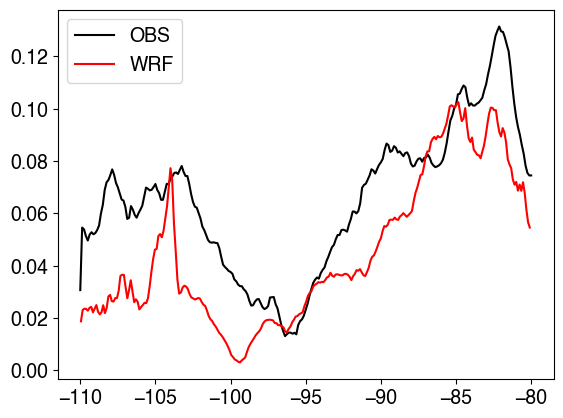

In [103]:
# Quicklook plot to check diurnal amplitude
plt.plot(lon_obs, amp_tot_obs_JJA[:,0], 'k', label='OBS')
plt.plot(lon_wrf, amp_tot_wrf_JJA[:,0], 'r', label='WRF')
plt.legend()

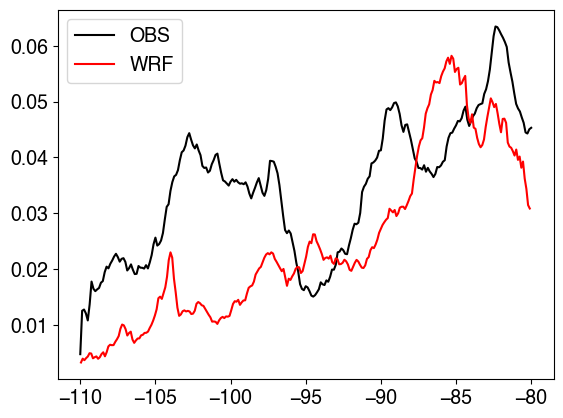

In [104]:
plt.plot(lon_obs, amp_mcs_obs_JJA[:,0], 'k', label='OBS')
plt.plot(lon_wrf, amp_mcs_wrf_JJA[:,0], 'r', label='WRF')
plt.legend()

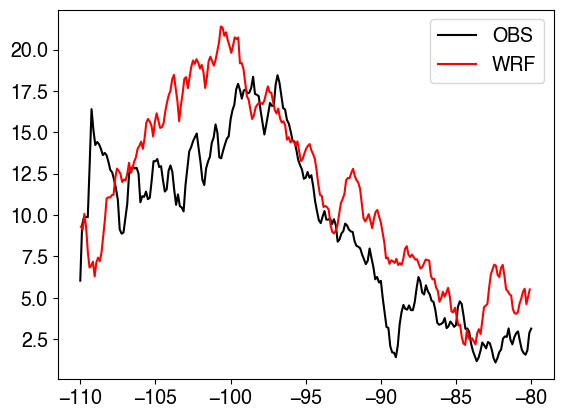

In [105]:
plt.plot(lon_obs, amp_mcsfrac_obs_JJA[:,0], 'k', label='OBS')
plt.plot(lon_wrf, amp_mcsfrac_wrf_JJA[:,0], 'r', label='WRF')
plt.legend()

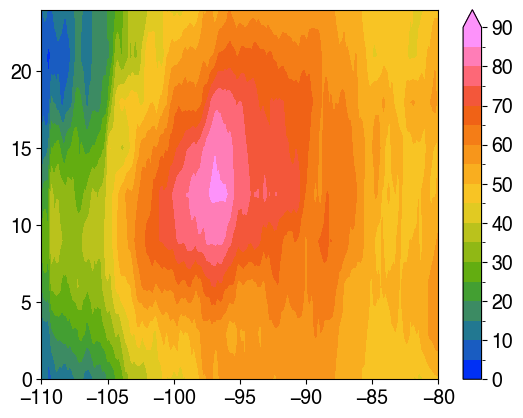

In [106]:
# Quicklook plot for MCS fraction
cmap = cc.cm.CET_R1
levels = np.arange(0, 91, 5)
norm = mpl.colors.BoundaryNorm(boundaries=levels, ncolors=cmap.N)
plt.contourf(lon_obs, hours, mcspcpfrac_obsE_JJA, levels=levels, norm=norm, cmap=cmap, extend='max')
plt.colorbar()

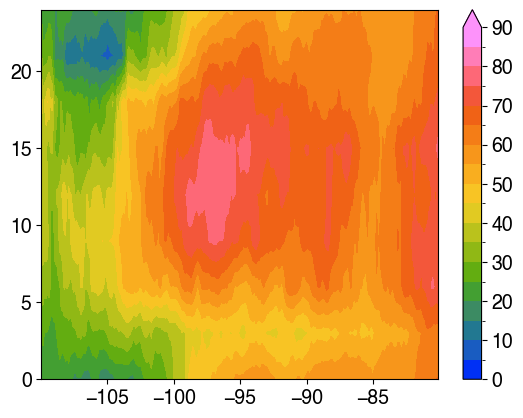

In [107]:
# Quicklook plot for MCS fraction
cmap = cc.cm.CET_R1
levels = np.arange(0, 91, 5)
norm = mpl.colors.BoundaryNorm(boundaries=levels, ncolors=cmap.N)
plt.contourf(lon_wrf, hours, mcspcpfrac_wrfE_JJA, levels=levels, norm=norm, cmap=cmap, extend='max')
plt.colorbar()

## Function to plot diurnal Hovmoller composites

In [108]:
def plot_hov_amp(lonarr, time, dataarr, amparr, ampmax, amplabel, ampcolor, levels, cmap, titles, cblabel, figname,
                 xlim=None, reg_lons=None, reg_text=None, reg_colors=None):

    mpl.rcParams['font.size'] = 14
    mpl.rcParams['font.weight'] = 'regular'
    mpl.rcParams['font.family'] = 'Helvetica'

    fig = plt.figure(figsize=[16,12], dpi=100)

    xlabels = ['','','','','Longitude','Longitude']
    ylabels = ['Local Time (hour)','','Local Time (hour)','','Local Time (hour)','']
    ylabels2 = ['',amplabel,'',amplabel,'',amplabel]

    gs = gridspec.GridSpec(3,3, height_ratios=[1,1,1], width_ratios=[0.8,0.8,0.03])
    gs.update(left=0.1, right=0.95, bottom=0.1, top=0.9, wspace=0.3, hspace=0.25)

    # Loop over each panel
    panels = [0,1,3,4,6,7]  # Skip colorbars
    for i, pp in enumerate(panels):
        pp = panels[i]
        ax = plt.subplot(gs[pp])
        cs = ax.contourf(lonarr[i], time, dataarr[i], levels[i], cmap=cmap[i], extend='both')
        ax.plot(xlim, (12,12), 'k--')
        ax.set_xlabel(xlabels[i], fontweight='regular')
        ax.set_ylabel(ylabels[i], fontweight='regular')
        ax.set_title(titles[i], loc='left', fontweight='regular')
        ax.set_xlim(xlim)
        # Plot colorbar for specific panels
        if ((pp == 1) | (pp == 4) | (pp == 7)):
            cax1 = plt.subplot(gs[pp+1])
            cb1 = plt.colorbar(cs, cax=cax1, label=cblabel[pp], orientation='vertical')
        # Annotate Great Plains
        if reg_lons is not None:
            ax.axvline(x=min(reg_lons), color=reg_colors[pp], ls='--', lw=2)
            ax.axvline(x=max(reg_lons), color=reg_colors[pp], ls='--', lw=2)
            ax.text(-96, 21, reg_text, color=reg_colors[pp], fontsize=20, ha='center', clip_on=True, weight='bold')
        
        ax2 = ax.twinx()
        p2 = ax2.plot(lonarr[i], amparr[i], color=ampcolor[i], lw=2)
        ax2.yaxis.label.set_color(ampcolor[i])
        ax2.set_ylabel(ylabels2[i])
        tkw = dict(size=5, width=1.5)
        ax2.tick_params(axis='y', colors=ampcolor[i], **tkw)
        ax2.set_ylim(0, ampmax[i])

        # Draw an arrow to show the direction of time increase
        if (pp == 0) | (pp == 3) | (pp == 6):
            ax.annotate('', xy=(-0.15, 1), xycoords='axes fraction', xytext=(-0.15, 0), 
                        arrowprops=dict(arrowstyle="->", facecolor='k', lw=3))

    fig.savefig(figname, dpi=300, bbox_inches='tight', facecolor='w')
    return fig

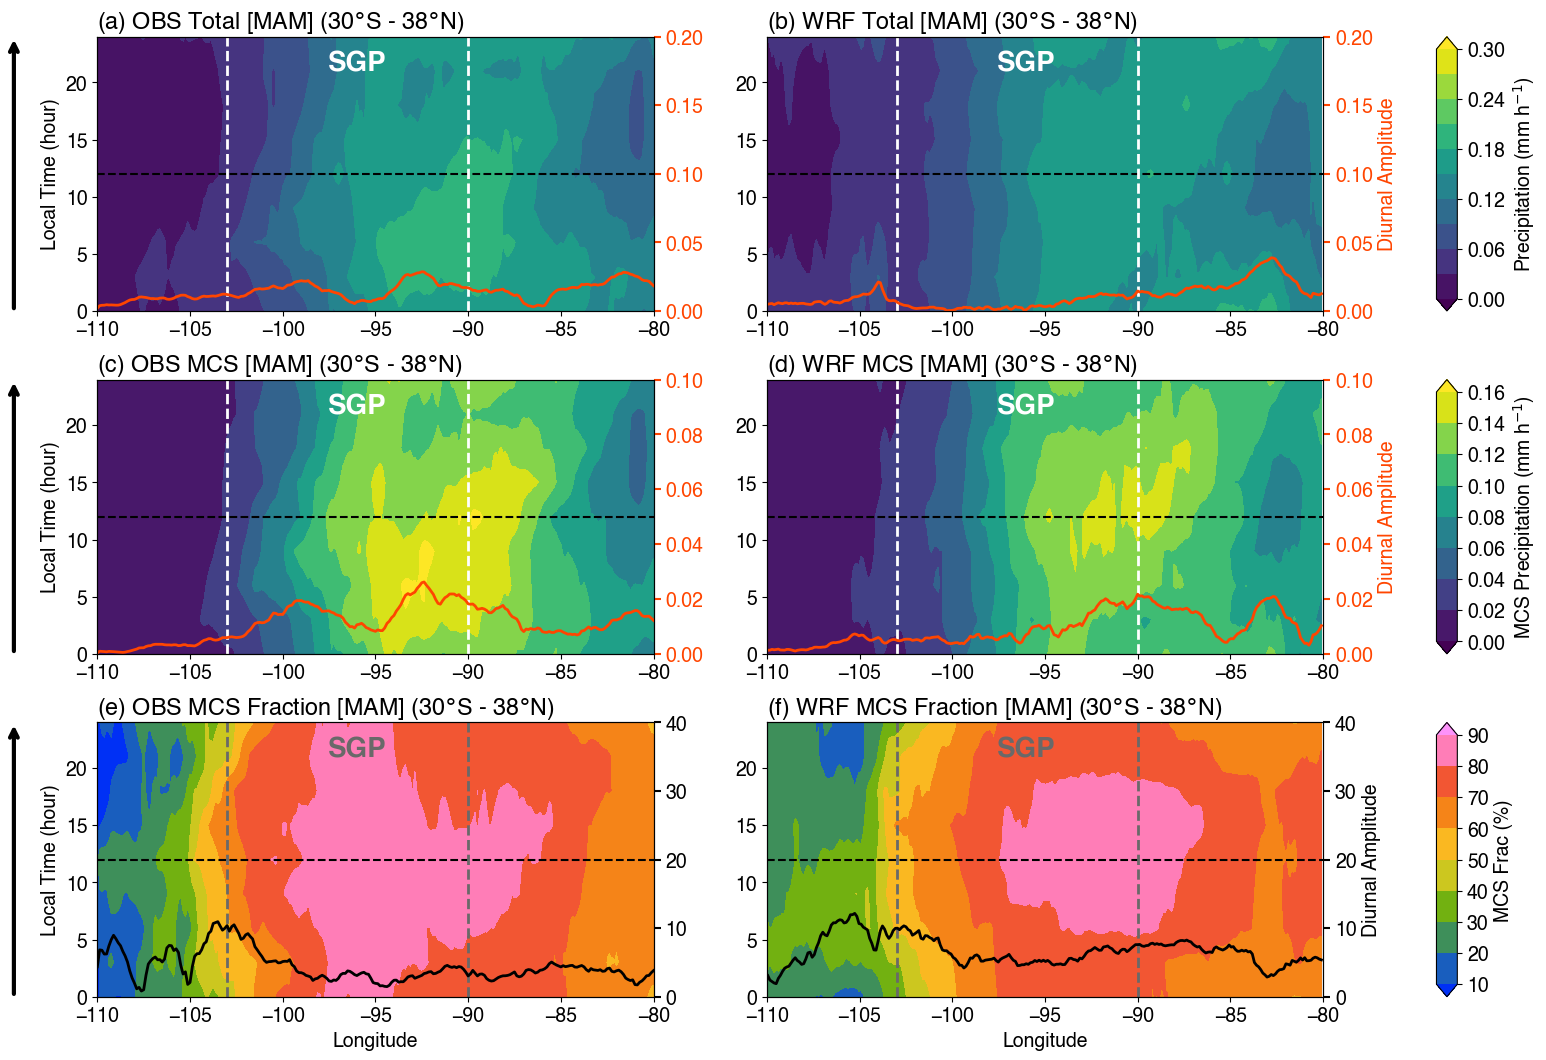

In [109]:
lonarr = [lon_obs, lon_wrf, lon_obs, lon_wrf, lon_obs, lon_wrf]
dataarr = [totpcphovdiur_obsE_MAM, totpcphovdiur_wrfE_MAM, 
           mcspcphovdiur_obsE_MAM, mcspcphovdiur_wrfE_MAM, 
           mcspcpfrac_obsE_MAM, mcspcpfrac_wrfE_MAM,]
amparr = [amp_tot_obs_MAM[:,0], amp_tot_wrf_MAM[:,0], 
          amp_mcs_obs_MAM[:,0], amp_mcs_wrf_MAM[:,0],  
          amp_mcsfrac_obs_MAM[:,0], amp_mcsfrac_wrf_MAM[:,0],]
ampmax = [0.2, 0.2, 0.1, 0.1, 40, 40]
levelstot = np.arange(0, 0.301, 0.03)
levelsmcs = np.arange(0, 0.161, 0.02)
levelsfrac = np.arange(10, 90.1, 10)
levelsarr = [levelstot, levelstot, levelsmcs, levelsmcs, levelsfrac, levelsfrac]
amplabel = 'Diurnal Amplitude'
ampcolor = ['orangered','orangered','orangered','orangered','k','k']
cmapfrac = cc.cm.CET_R1
cmaparr = ['viridis','viridis','viridis','viridis',cmapfrac,cmapfrac]
cblabel = ['Precipitation (mm h$^{-1}$)','Precipitation (mm h$^{-1}$)','Precipitation (mm h$^{-1}$)',
           'MCS Precipitation (mm h$^{-1}$)','MCS Precipitation (mm h$^{-1}$)','MCS Precipitation (mm h$^{-1}$)',
           'MCS Frac (%)','MCS Frac (%)','MCS Frac (%)',]
lat_min, lat_max = dsobs.attrs['startlat'], dsobs.attrs['endlat']
lat_band = f' ({np.abs(lat_min):.0f}' + r'$\degree$S - ' + f'{np.abs(lat_max):.0f}' + r'$\degree$N)'
xlim = (dsobs.attrs['startlon'], dsobs.attrs['endlon'])
titles = ['(a) OBS Total [MAM]'+lat_band,'(b) WRF Total [MAM]'+lat_band,
          '(c) OBS MCS [MAM]'+lat_band,'(d) WRF MCS [MAM]'+lat_band,
          '(e) OBS MCS Fraction [MAM]'+lat_band,'(f) WRF MCS Fraction [MAM]'+lat_band,]
reg_lons = [-103., -90]
reg_colors = ['white','white','white','white','white','white','dimgray','dimgray','dimgray']
reg_text = region
figname = f'{figdir}imerg_wrf_tot_mcs_rainhov_diurnal_{region}_MAM.png'

fig = plot_hov_amp(lonarr, hours, dataarr, amparr, ampmax, amplabel, ampcolor, levelsarr, cmaparr, titles, cblabel, figname,
                   xlim=xlim, reg_lons=reg_lons, reg_colors=reg_colors, reg_text=reg_text)

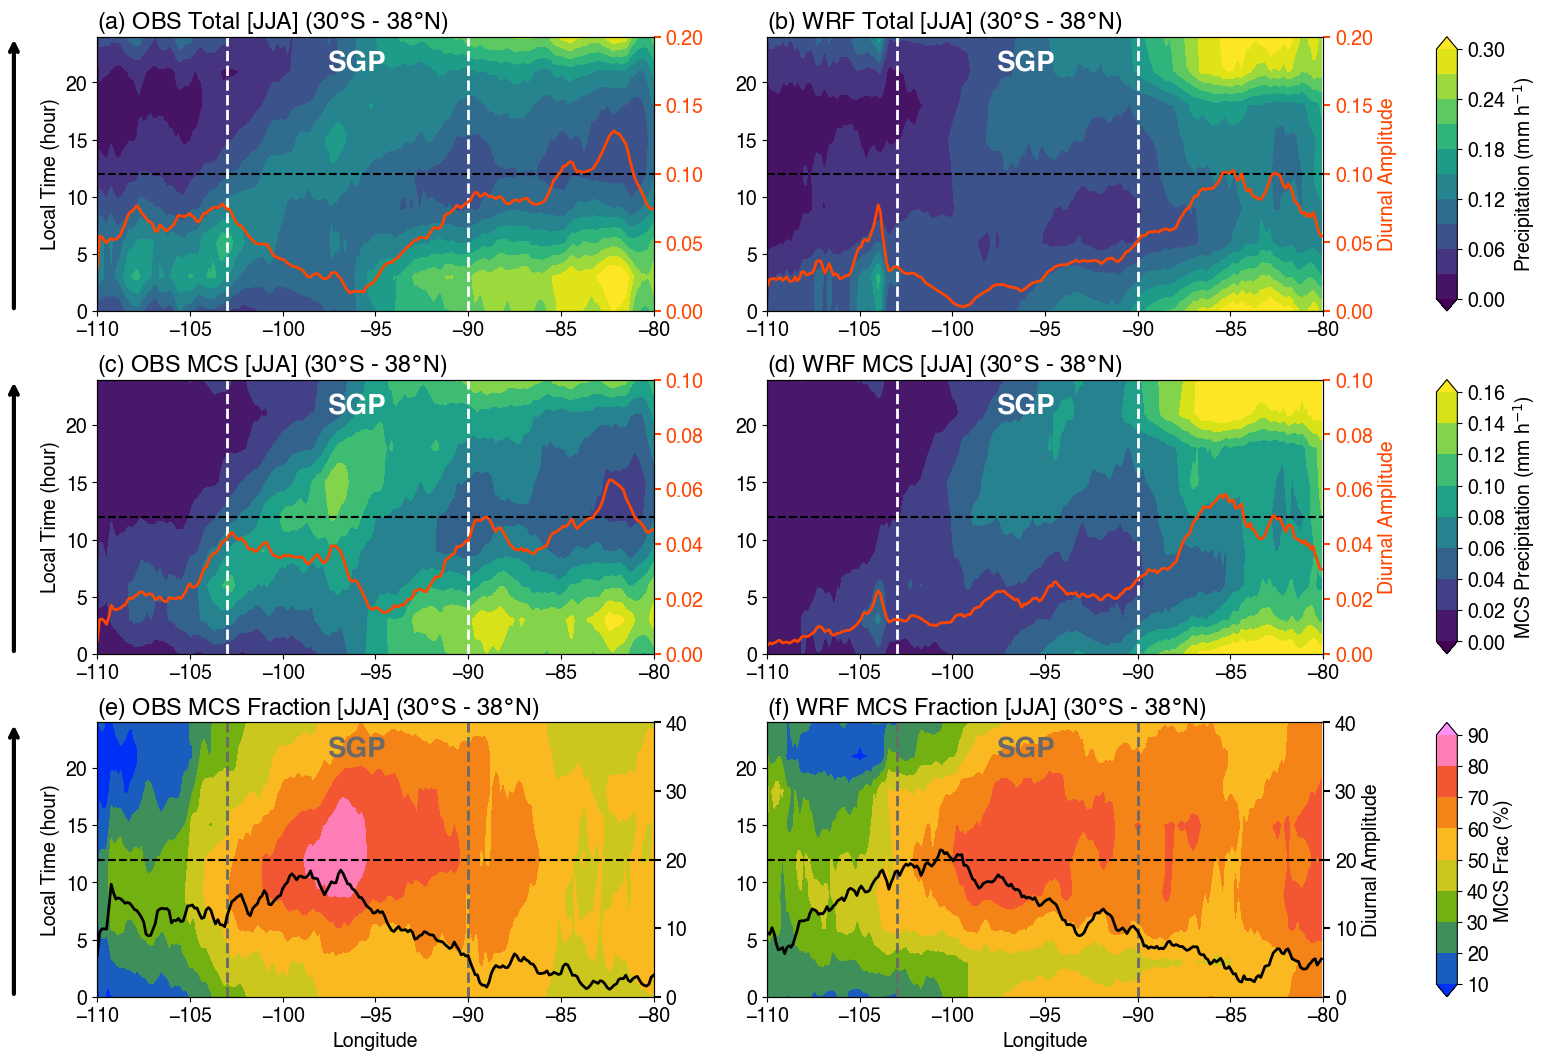

In [110]:
lonarr = [lon_obs, lon_wrf, lon_obs, lon_wrf, lon_obs, lon_wrf]
dataarr = [totpcphovdiur_obsE_JJA, totpcphovdiur_wrfE_JJA, 
           mcspcphovdiur_obsE_JJA, mcspcphovdiur_wrfE_JJA, 
           mcspcpfrac_obsE_JJA, mcspcpfrac_wrfE_JJA,]
amparr = [amp_tot_obs_JJA[:,0], amp_tot_wrf_JJA[:,0], 
          amp_mcs_obs_JJA[:,0], amp_mcs_wrf_JJA[:,0],  
          amp_mcsfrac_obs_JJA[:,0], amp_mcsfrac_wrf_JJA[:,0],]
ampmax = [0.2, 0.2, 0.1, 0.1, 40, 40]
levelstot = np.arange(0, 0.301, 0.03)
levelsmcs = np.arange(0, 0.161, 0.02)
levelsfrac = np.arange(10, 90.1, 10)
levelsarr = [levelstot, levelstot, levelsmcs, levelsmcs, levelsfrac, levelsfrac]
amplabel = 'Diurnal Amplitude'
ampcolor = ['orangered','orangered','orangered','orangered','k','k']
cmapfrac = cc.cm.CET_R1
cmaparr = ['viridis','viridis','viridis','viridis',cmapfrac,cmapfrac]
cblabel = ['Precipitation (mm h$^{-1}$)','Precipitation (mm h$^{-1}$)','Precipitation (mm h$^{-1}$)',
           'MCS Precipitation (mm h$^{-1}$)','MCS Precipitation (mm h$^{-1}$)','MCS Precipitation (mm h$^{-1}$)',
           'MCS Frac (%)','MCS Frac (%)','MCS Frac (%)',]
lat_min, lat_max = dsobs.attrs['startlat'], dsobs.attrs['endlat']
lat_band = f' ({np.abs(lat_min):.0f}' + r'$\degree$S - ' + f'{np.abs(lat_max):.0f}' + r'$\degree$N)'
xlim = (dsobs.attrs['startlon'], dsobs.attrs['endlon'])
titles = ['(a) OBS Total [JJA]'+lat_band,'(b) WRF Total [JJA]'+lat_band,
          '(c) OBS MCS [JJA]'+lat_band,'(d) WRF MCS [JJA]'+lat_band,
          '(e) OBS MCS Fraction [JJA]'+lat_band,'(f) WRF MCS Fraction [JJA]'+lat_band,]
reg_lons = [-103., -90]
reg_colors = ['white','white','white','white','white','white','dimgray','dimgray','dimgray']
reg_text = region
figname = f'{figdir}imerg_wrf_tot_mcs_rainhov_diurnal_{region}_MAM.png'

fig = plot_hov_amp(lonarr, hours, dataarr, amparr, ampmax, amplabel, ampcolor, levelsarr, cmaparr, titles, cblabel, figname,
                   xlim=xlim, reg_lons=reg_lons, reg_colors=reg_colors, reg_text=reg_text)

In [111]:
figdir

'/global/cfs/cdirs/m2637/zfeng/TGW_MCS/figures/'